In [33]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
import pandas as pd

from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report

In [17]:
class CustomDataset(Dataset):

    def __init__(self, dataframe: pd.DataFrame, feature_names: list, target_name: str):
        scaler = StandardScaler()
        X = scaler.fit_transform(dataframe[feature_names])
        X = torch.tensor(X, dtype=torch.float32)
        
        self.X = X.reshape(X.shape[0], 1, X.shape[1])
        self.y = torch.tensor(dataframe[target_name].values, dtype=torch.float32)
        
    def __len__(self) -> int:
        return len(self.y)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [18]:
df = pd.read_csv("data\df_01.csv", index_col=[0])
df = df.reset_index().drop(columns=['index'])

In [19]:
lithology_keys = {30000: 0,
                  65030: 1,
                  65000: 2,
                  80000: 3,
                  74000: 4,
                  70000: 5,
                  70032: 6,
                  88000: 7,
                  86000: 8,
                  99000: 9,
                  90000: 10,
                  93000: 11}

In [20]:
df['FORCE_2020_LITHOFACIES_LITHOLOGY'] = df['FORCE_2020_LITHOFACIES_LITHOLOGY'].map(lithology_keys)

In [21]:
encoder = OneHotEncoder(sparse_output=False)
one_hot_ecoded = encoder.fit_transform(df[['FORCE_2020_LITHOFACIES_LITHOLOGY']])
one_hot_df = pd.DataFrame(one_hot_ecoded, columns=encoder.get_feature_names_out())

In [22]:
df = pd.concat([df, one_hot_df], axis=1)

In [23]:
feature_names = ['DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'CALI', 'RMED', 'RDEP', 'RHOB',
                 'GR', 'NPHI', 'PEF', 'DTC', 'BS', 'ROP', 'DTS', 'DCAL', 'DRHO', 'ROPA']

target_name = ['FORCE_2020_LITHOFACIES_LITHOLOGY_0', 'FORCE_2020_LITHOFACIES_LITHOLOGY_1', 
               'FORCE_2020_LITHOFACIES_LITHOLOGY_2', 'FORCE_2020_LITHOFACIES_LITHOLOGY_3',
               'FORCE_2020_LITHOFACIES_LITHOLOGY_4', 'FORCE_2020_LITHOFACIES_LITHOLOGY_5',
               'FORCE_2020_LITHOFACIES_LITHOLOGY_6', 'FORCE_2020_LITHOFACIES_LITHOLOGY_7', 
               'FORCE_2020_LITHOFACIES_LITHOLOGY_8', 'FORCE_2020_LITHOFACIES_LITHOLOGY_9',
               'FORCE_2020_LITHOFACIES_LITHOLOGY_10']

In [24]:
df_test = df.sample(frac=0.2)
df_train = df.loc[~df.index.isin(df_test.index)]

In [25]:
train_dataset = CustomDataset(dataframe=df_train, feature_names=feature_names, target_name=target_name)
train_data = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True, )

test_dataset = CustomDataset(dataframe=df_test, feature_names=feature_names, target_name=target_name)
test_data = DataLoader(dataset=test_dataset, batch_size=64, shuffle=True, )

In [26]:
model = nn.Sequential(
    nn.Conv1d(1, 64, 3, padding=1),
    nn.ReLU(),
    nn.Conv1d(64, 64, 3, padding=1),
    nn.ReLU(),
    nn.Conv1d(64, 64, 3, padding=1),
    nn.ReLU(),
    
    nn.Flatten(),
    nn.Linear(1152, 32), 
    nn.ReLU(),
    nn.Linear(32, 11),
)

#RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x1152 and 18x32)


In [27]:
optimizer = optim.Adam(params=model.parameters(), lr=0.001, weight_decay=0.001)
loss_function = nn.CrossEntropyLoss()

In [28]:
epochs = 5
model.train()

Sequential(
  (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (1): ReLU()
  (2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (3): ReLU()
  (4): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (5): ReLU()
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=1152, out_features=32, bias=True)
  (8): ReLU()
  (9): Linear(in_features=32, out_features=11, bias=True)
)

In [29]:
for e in range(epochs):
    loss_mean = 0
    lm_count = 0

    train_tqdm = tqdm(train_data, leave=True)
    for x_train, y_train in train_tqdm:
        predict = model(x_train)
        loss = loss_function(predict, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        lm_count += 1
        loss_mean = 1/lm_count * loss.item() + (1 - 1/lm_count) * loss_mean
        train_tqdm.set_description(f'Epoch [{e+1}/{epochs}], loss_mean={loss_mean:.3f} ')

Epoch [5/5], loss_mean=0.298 : 100%|██████████| 1518/1518 [01:04<00:00, 23.50it/s]


In [31]:
model.eval()

Sequential(
  (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (1): ReLU()
  (2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (3): ReLU()
  (4): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (5): ReLU()
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=1152, out_features=32, bias=True)
  (8): ReLU()
  (9): Linear(in_features=32, out_features=11, bias=True)
)

In [32]:
predictions = []
tests = []
test_tqdm = tqdm(test_data, leave=True)
for x_test, y_test in test_tqdm:
    predict = model(x_test)
    predict = torch.argmax(predict, dim=1)
    y_test = torch.argmax(y_test, dim=1)
    predictions.extend(predict.cpu().detach().numpy().tolist())
    tests.extend(y_test.cpu().detach().numpy().tolist())

100%|██████████| 380/380 [00:09<00:00, 38.46it/s]


In [34]:
print(classification_report(tests, predictions))

              precision    recall  f1-score   support

           0       0.79      0.91      0.85      2929
           1       0.79      0.63      0.70      2116
           2       0.95      0.95      0.95     13697
           3       0.80      0.76      0.78      1064
           4       0.67      0.12      0.20        50
           5       0.78      0.79      0.79      1823
           6       0.93      0.93      0.93       611
           7       0.98      1.00      0.99      1312
           8       0.79      0.78      0.79       136
           9       0.87      0.86      0.86       507
          10       0.96      0.60      0.74        40

    accuracy                           0.89     24285
   macro avg       0.85      0.76      0.78     24285
weighted avg       0.89      0.89      0.89     24285



<Axes: >

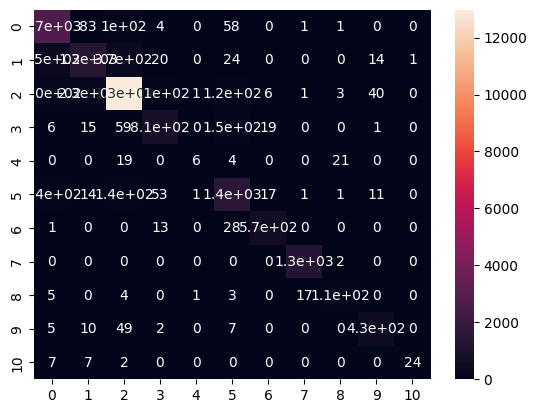

In [35]:
cm = confusion_matrix(tests, predictions)
sns.heatmap(cm, annot=True)